In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.context("plotly_white")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import pickle
from sklearn.metrics import r2_score

In [2]:
last_date = 95
R0 = 2.5

us_state_abbrev = pickle.load(open("data/us_state_abbrev.pkl", "rb"))
state_codes = pickle.load(open("data/state_codes.pkl", "rb"))

df = pd.read_csv("data/us_data.csv")
df['date'] = pd.to_datetime(df['date'])
us_df = df[['date', 'daily_cases', 'daily_deaths']]
case_df = us_df.set_index('date').resample('W-Sat').sum().copy()
case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
case_df = case_df.iloc[:last_date]

## Figure 1
Fit to US Cases and Example of Integral Policy

In [3]:
out_sample_size = 69 ## number of weeks of testing data
start_integrator = 30 ## number of weeks at which to start the proposed integral policy

In [4]:
new_df = pd.DataFrame(index=case_df.index)

## X2(t) is log of current cases, X1(t) is log of previous cases
new_df['X2(t)'] = np.log(case_df['weekly_cases'])
new_df['X1(t)'] = np.log(case_df['weekly_cases']).shift(1).fillna(0)
new_df['sX(t-1)'] = new_df['X1(t)'].iloc[-start_integrator:].cumsum().fillna(0)

## X3(t) is cumulative degree pruning
new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)

In [5]:
## Assume that degree pruning is a function of previous cases and previous degree pruning
X = new_df[['X1(t)', 'X3(t-1)']]
X = sm.add_constant(X)
X_train = X.iloc[:-out_sample_size]
X_test = X.iloc[-out_sample_size:]

## Degree pruning parameter is equal to difference in cumulative values
y = new_df['X3(t)'] - new_df['X3(t-1)']
y_train = y.iloc[:-out_sample_size]
y_test = y.iloc[-out_sample_size:]

In [6]:
## learn beta1 and beta2
model = sm.OLS(y_train,X_train)
results = model.fit()

In [7]:
beta_S = -1e-2
new_df['InSample'] = results.predict(X_train) + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)
new_df['OutSample'] = results.predict(X.iloc[-(out_sample_size+1):]) + new_df['X1(t)'] + \
                        new_df['X3(t-1)'] + np.log(R0)
new_df['Integrator'] = results.predict(X.iloc[-(start_integrator+1):]) + beta_S * new_df['sX(t-1)'] + \
                        new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)

new_df['Actual'] = np.exp(new_df['X2(t)'])
new_df['Fit (In Sample)'] = np.exp(new_df['InSample'])
new_df['Fit (Out of Sample)'] = np.exp(new_df['OutSample'])
new_df['Proposed Feedback Policy'] = np.exp(new_df['Integrator'])

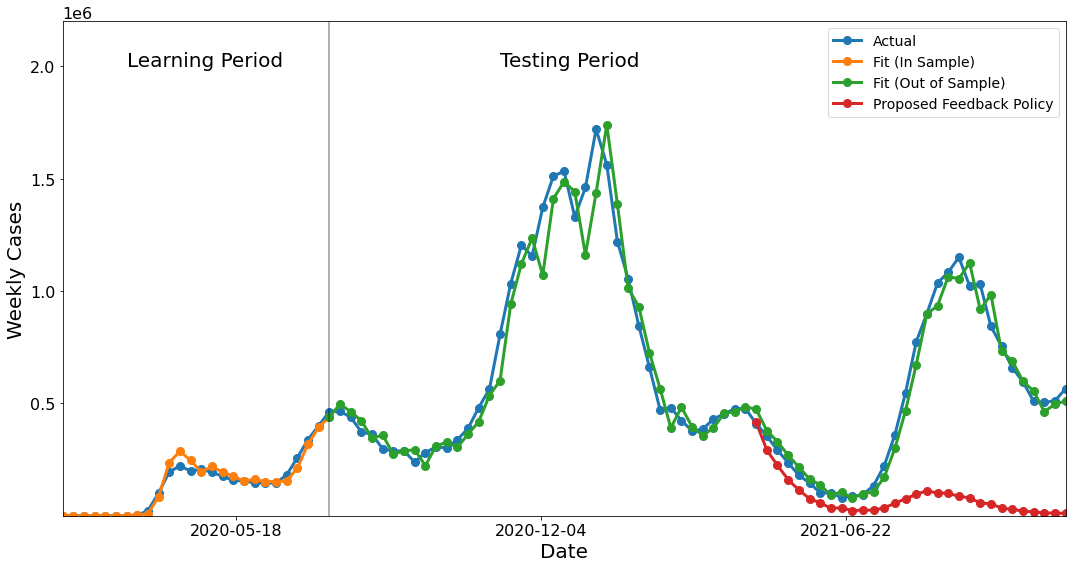

In [8]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(15, 8))
#new_df.plot(y=['Actual', 'Fit (In Sample)', 'Fit (Out of Sample)'], ax=ax, style='o-', ms=4)
ax.plot(new_df.index, new_df['Actual'], 'o-', 
        label="Actual", ms=8, linewidth=3)
ax.plot(new_df.index, new_df['Fit (In Sample)'], 'o-', 
        label='Fit (In Sample)', ms=8, linewidth=3)
ax.plot(new_df.index, new_df['Fit (Out of Sample)'], 'o-', 
        label='Fit (Out of Sample)', ms=8, linewidth=3)
ax.plot(new_df.index, new_df['Proposed Feedback Policy'], 'o-', 
        label='Proposed Feedback Policy', ms=8, linewidth=3)
ax.axvline(new_df[~new_df['OutSample'].isnull()].index[0], color='black', alpha=0.4)
plt.text(new_df.index[6], 2e6, "Learning Period", 
         fontsize=20)
plt.text(new_df.index[41], 2e6, "Testing Period", 
         fontsize=20)

ax.set_xlabel("Date", fontsize=20)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_ylabel("Weekly Cases", fontsize=20)
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlim([new_df.index[0], new_df.index[-1]])
ax.legend(loc=1, prop={'size': 14})
ax.set_ylim([0.001, 2.2e6])
fig.tight_layout()
# fig.savefig("us_lds_int_preds.png", dpi=300)

In [9]:
insample_idx = ~new_df['Fit (In Sample)'].isnull()
outsample_idx = new_df['Fit (In Sample)'].isnull()

insample_df = new_df[insample_idx]
outsample_df = new_df[outsample_idx]

print(r2_score(insample_df['Fit (In Sample)'], insample_df['Actual']))
print(r2_score(outsample_df['Fit (Out of Sample)'], outsample_df['Actual']))

0.9664105837730061
0.948757009242062


## Figure 7
Replication of Integral Policy

In [10]:
new_df['integral_degree_prune'] = results.predict(X.iloc[-(start_integrator+1):]) + beta_S * new_df['sX(t-1)']

In [11]:
betas = []

## Assume that degree pruning is a function of previous cases and previous degree pruning
X = new_df[['X1(t)', 'X3(t-1)']]
X = sm.add_constant(X)
X_train = X.iloc[-start_integrator:]

## Degree pruning parameter is equal to difference in cumulative values
y = new_df['integral_degree_prune']
y_train = y.iloc[-start_integrator:]

model = sm.OLS(y_train,X_train)
results = model.fit()

date = X.index[-1]
betas.append({
    'date': date,
    'Time Since Integral Policy Implemented': 27,
    "$\\beta_1$": results.params['X1(t)'],
    "$\\beta_2$": results.params['X3(t-1)'],
    'const': results.params['const']
})

for vals in range(1, start_integrator - 2):
    ## Assume that degree pruning is a function of previous cases and previous degree pruning
    X = new_df[['X1(t)', 'X3(t-1)']]
    X = sm.add_constant(X)
    X_train = X.iloc[-start_integrator:-vals]

    ## Degree pruning parameter is equal to difference in cumulative values
    y = new_df['integral_degree_prune']
    y_train = y.iloc[-start_integrator:-vals]
    
    model = sm.OLS(y_train,X_train)
    results = model.fit()
    
    date = X.index[-(vals + 1)]
    betas.append({
        'date': date,
        'Time Since Integral Policy Implemented': 27 - vals,
        "$\\beta_1$": results.params['X1(t)'],
        "$\\beta_2$": results.params['X3(t-1)'],
        'const': results.params['const']
    })
    


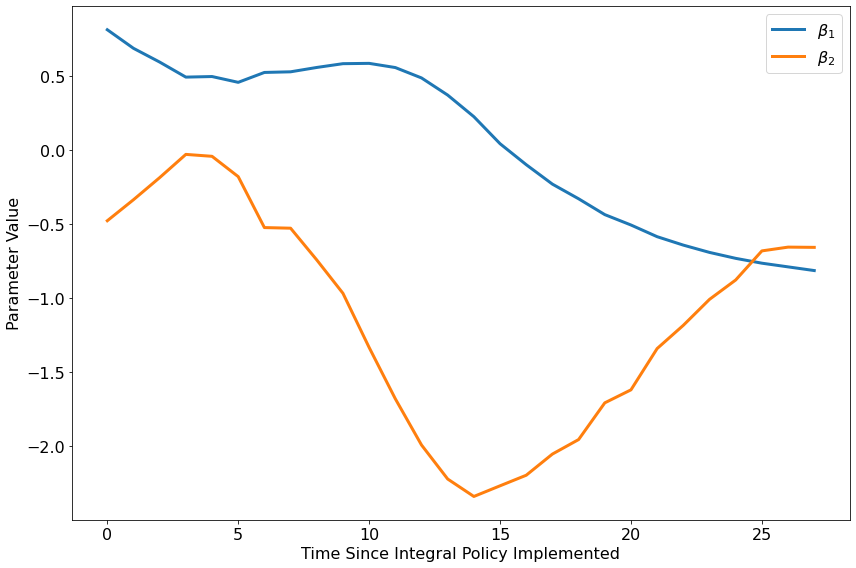

In [12]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame(betas).plot(x='Time Since Integral Policy Implemented', y=["$\\beta_1$", "$\\beta_2$"], ax=ax, linewidth=3)
plt.ylabel("Parameter Value", fontsize=16)
plt.xlabel("Time Since Integral Policy Implemented", fontsize=16)
plt.legend(prop={'size': 16})
fig.tight_layout()
# fig.savefig("beta_emulation.png", dpi=300)

## Figure 8, and Table 2
$r^2$ comparison between 1-week ahead CDC ensemble estimates, our model estimates for each state, and an SEIR model

In [13]:
forecast_df = pd.read_csv("data/cdc_forecasts_states.csv")

# ## Remove hospitalization data
forecast_df = forecast_df[~forecast_df['target'].str.contains('hosp')]

all_states = pd.unique(df['state'])
all_states = all_states[all_states != 'District of Columbia']

sir_forecast_df = pd.read_csv("data/simple_SEIR_preds.csv")
sir_forecast_df['forecast_target_date'] = pd.to_datetime(sir_forecast_df['forecast_target_date'])

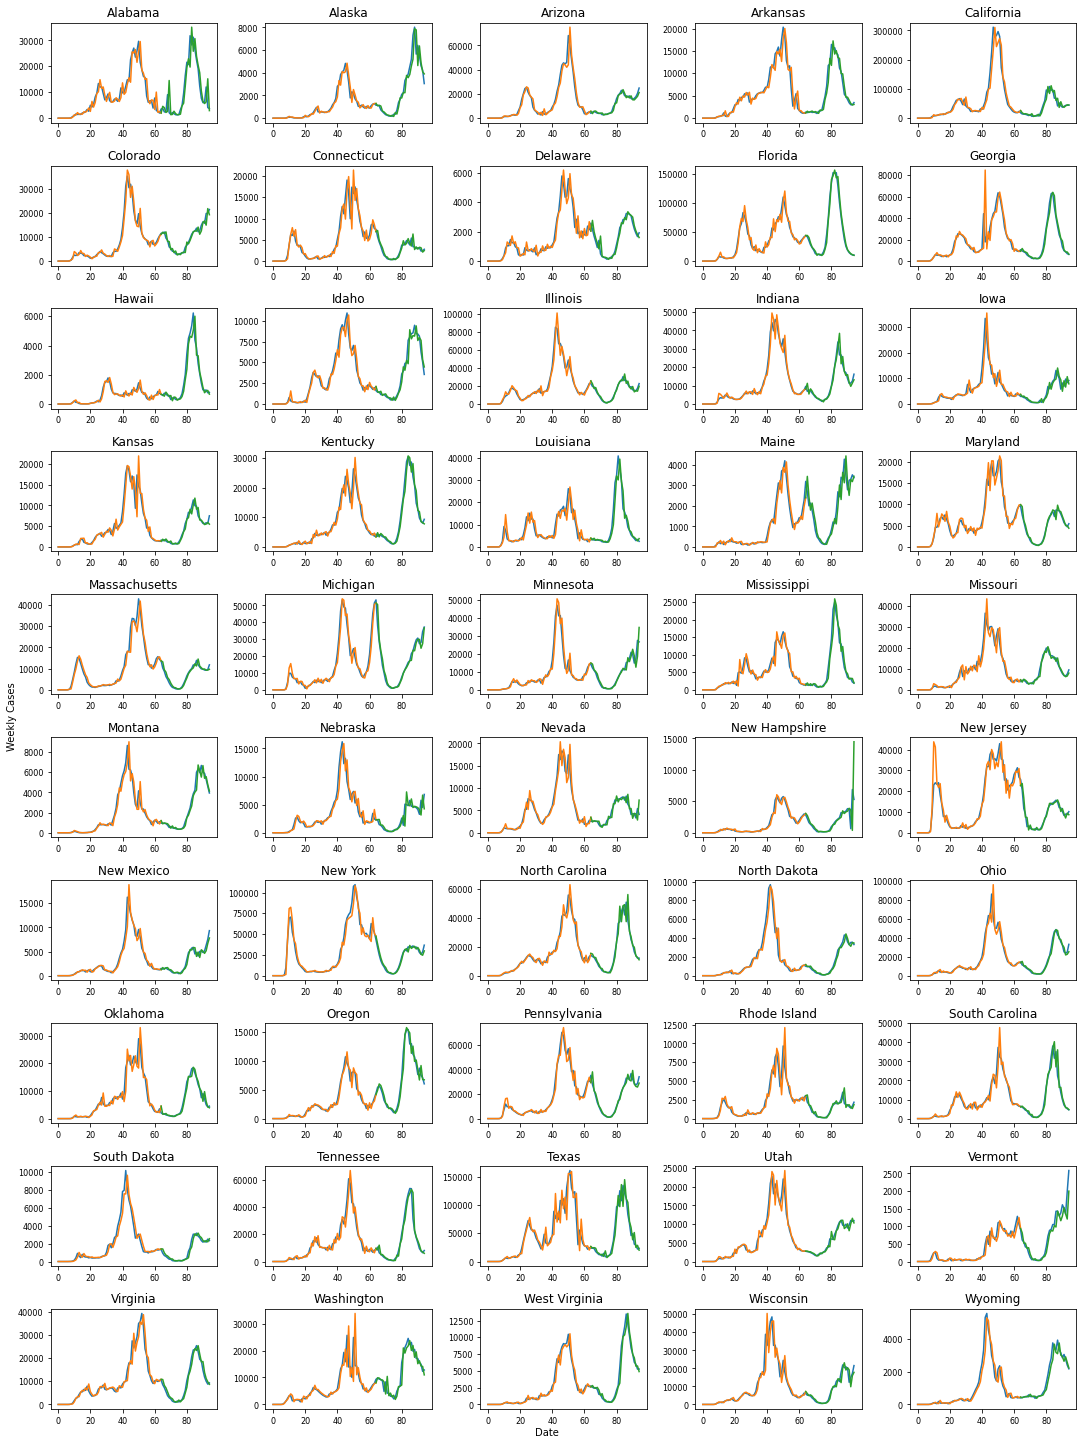

In [14]:
from copy import deepcopy
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
fig, axs = plt.subplots(10, 5, figsize=(15, 20))

rsquared_dict = {}
cdc_rsquared_dict = {}
sir_rsquared_dict = {}
results_dict = {}

out_sample_size = 30

for i, state in enumerate(all_states):
    
    # CDC R2
    cdc_df = deepcopy(forecast_df[(forecast_df['target'] == '1 wk ahead inc case') &
                                (forecast_df['location'] == state_codes[us_state_abbrev[state]])])
    cdc_df.loc[:, 'target_end_date'] = pd.to_datetime(cdc_df['target_end_date'])

    curr_df = df[df['state'] == state]
    case_df = curr_df.set_index('date').resample('W-Sat').sum()
    case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
    case_df = case_df.iloc[:last_date].reset_index()
    case_df.loc[:, 'date'] = pd.to_datetime(case_df['date'])


    full_df = pd.merge(case_df[-out_sample_size:], cdc_df[-out_sample_size:], 
                       left_on='date', right_on='target_end_date')
    cdc_rsquared_dict[state] = r2_score(full_df['value'], full_df['weekly_cases'])
    
    sir_df = sir_forecast_df[sir_forecast_df['state'] == state]
    full_df = pd.merge(case_df[-out_sample_size:], sir_df[-out_sample_size:], 
                       left_on='date', right_on='forecast_target_date')
    sir_rsquared_dict[state] = r2_score(full_df['prediction'], full_df['weekly_cases'])

    new_df = pd.DataFrame(index=case_df.index)
    new_df['X2(t)'] = np.log(case_df['weekly_cases'] + 1)
    new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1).shift(1).fillna(0)
    new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
    new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)


    ## Assume that degree pruning is a function of previous cases and previous degree pruning
    X = new_df[['X1(t)', 'X3(t-1)']]
    X = sm.add_constant(X)
    X_train = X.iloc[:-out_sample_size]
    X_test = X.iloc[-out_sample_size:]

    ## Degree pruning parameter is equal to difference in cumulative values
    y = new_df['X3(t)'] - new_df['X3(t-1)']
    y_train = y.iloc[:-out_sample_size]
    y_test = y.iloc[-out_sample_size:]


    ## learn beta1 and beta2
    model = sm.OLS(y_train,X_train)
    results = model.fit()

    new_df['InSample'] = results.predict(X_train) + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)
    new_df['OutSample'] = results.predict(X.iloc[-(out_sample_size+1):]) + new_df['X1(t)'] + \
                            new_df['X3(t-1)'] + np.log(R0)

    new_df['Actual'] = np.exp(new_df['X2(t)'])
    new_df['Fit (In Sample)'] = np.exp(new_df['InSample'])
    new_df['Fit (Out of Sample)'] = np.exp(new_df['OutSample'])

    insample_idx = ~new_df['Fit (In Sample)'].isnull()
    outsample_idx = new_df['Fit (In Sample)'].isnull()

    insample_df = new_df[insample_idx]
    outsample_df = new_df[outsample_idx]

    rsquared_dict[state] = {
        'insample': r2_score(insample_df['Fit (In Sample)'], insample_df['Actual']),
        'outsample': r2_score(outsample_df['Fit (Out of Sample)'], outsample_df['Actual']),
        'size': out_sample_size
    }
    results_dict[state] = results

    new_df.plot(y=['Actual', 'Fit (In Sample)', 'Fit (Out of Sample)'], ax=axs[int(i/5)][i % 5], legend=False)
    axs[int(i/5)][i % 5].set_title(state)
    axs[int(i/5)][i % 5].set_ylabel("")
    axs[int(i/5)][i % 5].set_xlabel("")
        

fig.patch.set_facecolor('white')

handles, labels = axs[int(i/5)][i % 5].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper left')
fig.text(0.5, 0.0, 'Date', ha='center')
fig.text(0.0, 0.5, 'Weekly Cases', va='center', rotation='vertical')

fig.tight_layout()

# plt.savefig("state_system_fits.png")        
        
rsquared_df = pd.DataFrame(rsquared_dict).T.reset_index().rename(columns={'index':'state'})

cdc_rsquared_df = pd.DataFrame.from_dict(cdc_rsquared_dict, orient='index').reset_index()
cdc_rsquared_df.columns = ['state', 'cdc_r2']

sir_rsquared_df = pd.DataFrame.from_dict(sir_rsquared_dict, orient='index').reset_index()
sir_rsquared_df.columns = ['state', 'sir_r2']

In [15]:
combined_r2_df = pd.merge(rsquared_df, cdc_rsquared_df, on='state')
combined_r2_df = pd.merge(combined_r2_df, sir_rsquared_df, on='state')
combined_r2_df = combined_r2_df.set_index('state')

In [16]:
# Table 2
print(combined_r2_df[['outsample', 'cdc_r2', 'sir_r2']].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  outsample &    cdc\_r2 &     sir\_r2 \\
state          &            &           &            \\
\midrule
Alabama        &   0.761268 &  0.870218 &  -7.466713 \\
Alaska         &   0.895081 &  0.860655 &  -6.097458 \\
Arizona        &   0.948373 &  0.912740 & -16.846574 \\
Arkansas       &   0.919352 &  0.904562 &  -5.102133 \\
California     &   0.846362 &  0.815874 & -38.857268 \\
Colorado       &   0.912670 &  0.928491 & -17.163285 \\
Connecticut    &   0.787693 &  0.770680 & -13.130171 \\
Delaware       &   0.901341 &  0.960540 & -23.524277 \\
Florida        &   0.984187 &  0.934497 & -16.086748 \\
Georgia        &   0.967953 &  0.951781 & -29.483336 \\
Hawaii         &   0.910708 &  0.919715 &  -3.725094 \\
Idaho          &   0.936136 &  0.919588 & -86.226929 \\
Illinois       &   0.923297 &  0.902908 & -25.749134 \\
Indiana        &   0.902190 &  0.925885 & -61.444810 \\
Iowa           &   0.813681 &  0.777314 &  -8.914433 \\
Kansas         &  

In [17]:
combined_r2_df.mean()

insample      0.901890
outsample     0.891370
size         30.000000
cdc_r2        0.877309
sir_r2      -17.579035
dtype: float64

In [18]:
from scipy import stats
stats.ttest_ind(combined_r2_df['outsample'] , combined_r2_df['cdc_r2'])

Ttest_indResult(statistic=0.5708304107040125, pvalue=0.5694212529100937)

In [19]:
np.sum(combined_r2_df['outsample'] > combined_r2_df['cdc_r2'])

32

## Figure 2
Results when parameters are used across different states

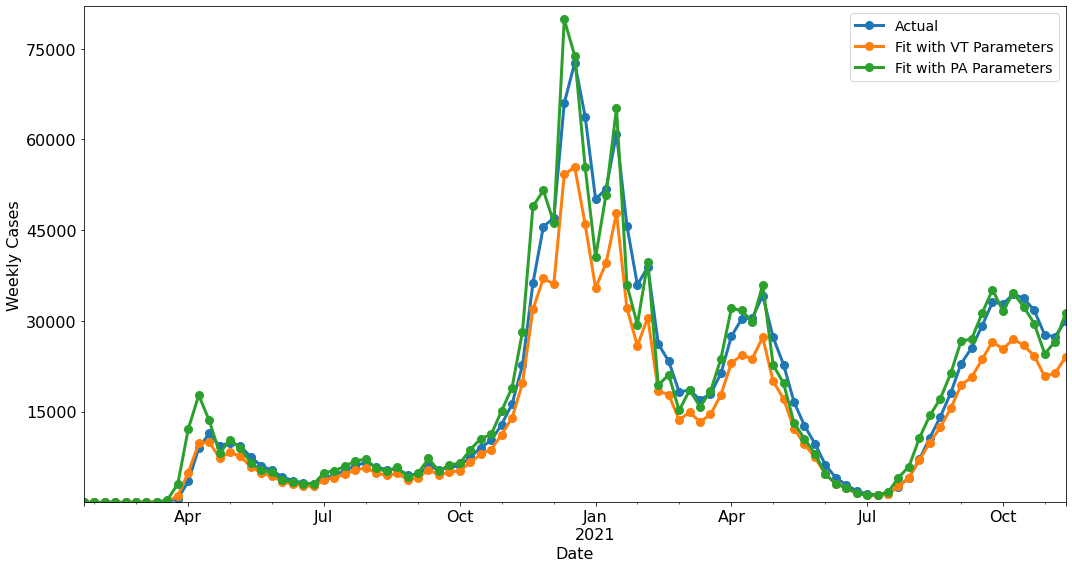

In [20]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(15, 8))

fig.patch.set_facecolor('white')

curr_df = df[df['state'] == "Pennsylvania"]
curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
case_df = curr_df.set_index('date').resample('W-Mon').sum()
case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths', 'date': 'Date'})
case_df = case_df.iloc[:last_date]

new_df = pd.DataFrame(index=case_df.index)
new_df['X2(t)'] = np.log(case_df['weekly_cases'] + 1)
new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1).shift(1).fillna(0)
new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)

X = new_df[['X1(t)', 'X3(t-1)']]
X = sm.add_constant(X)

new_df['VT-PA'] = results_dict['Vermont'].predict(X)  + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)
new_df['PA-PA'] = results_dict['Pennsylvania'].predict(X)  + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)

new_df['Actual'] = np.exp(new_df['X1(t)'])
new_df['Fit with VT Parameters'] = np.exp(new_df['VT-PA'])
new_df['Fit with PA Parameters'] = np.exp(new_df['PA-PA'])

new_df.plot(y=['Actual', 'Fit with VT Parameters', 'Fit with PA Parameters'], ax=ax, linewidth=3, style='o-', ms=8)

ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Weekly Cases", fontsize=16)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.set_xlim([new_df.index[0], new_df.index[-1]])
ax.legend(loc=1, prop={'size': 14})
ax.set_ylim([0.001, 8.2e4])
fig.tight_layout()

# plt.savefig("pa_vt_fit.png")

## Figure 3
Steady state case counts

In [21]:
coef_dict = {state: results.params for state, results in results_dict.items()}
coef_df = pd.DataFrame(coef_dict).T

In [22]:
def steady_state(x):
    beta1 = x['X1(t)']
    beta2 = x['X3(t-1)']
    beta3 = x['const']

    return (beta2 * np.log(R0) - beta3) / beta1

In [23]:
coef_df['steadystate'] = coef_df.apply(steady_state, axis=1)

pops = pd.read_excel("data/populations.xlsx", index_col=0)
pops = pops[[2019]].reset_index().dropna()
pops.columns = ['state', 'population']
pops['state'] = pops['state'].str.replace(".","")
pops = pops.set_index('state')
coef_df['pop'] = pops['population']

coef_df['Steady State Cases Per Capita'] = np.exp(coef_df['steadystate']) / coef_df['pop']

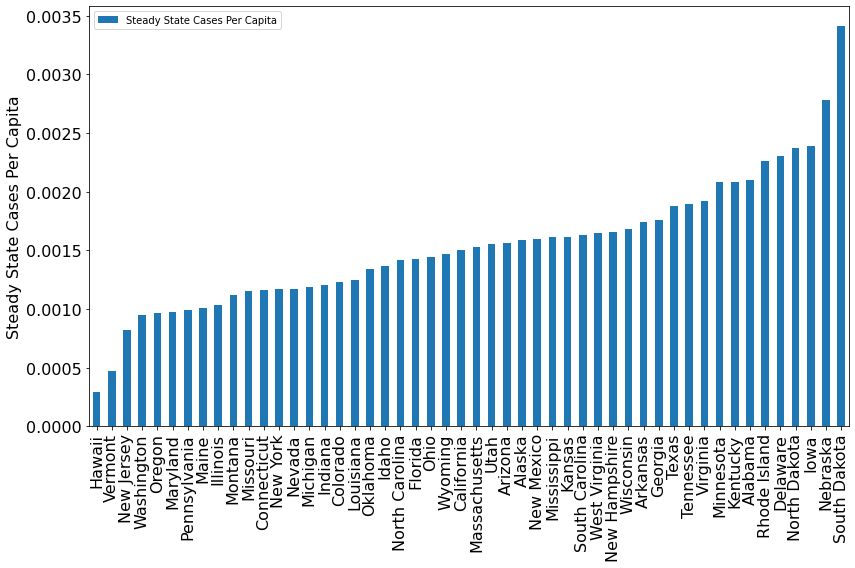

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
coef_df.sort_values(by='Steady State Cases Per Capita').plot.bar(y=['Steady State Cases Per Capita']
                                                                 , ax=ax)
ax.set_ylabel('Steady State Cases Per Capita', fontsize=16)
fig.patch.set_facecolor('white')
plt.tight_layout()
# plt.savefig("steadystate.png")

In [25]:
# comparison to actual values
from scipy.stats import pearsonr
week_dfs = []
for curr_state in all_states:
    curr_df = df[df['state'] == curr_state]
    curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
    case_df = curr_df.set_index('date').resample('W-Mon').sum()
    case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
    case_df = case_df.iloc[:last_date].reset_index()
    case_df['state'] = curr_state
    week_dfs.append(case_df)
    
week_df = pd.concat(week_dfs, ignore_index=True)
actual_cases = week_df[week_df['weekly_cases'] > 0].groupby("state").mean()

coef_df['Actual'] = actual_cases['weekly_cases'] / coef_df['pop']

pearsonr(coef_df['Actual'], coef_df['Steady State Cases Per Capita'])

(0.5965810325355224, 4.825899405551954e-06)

## Figure 4
Coefficients and relative size of pandemic

In [26]:
eps1 = 0.001
beta1s = np.arange(min(coef_df['X1(t)']) - 2*eps1, 
                   max(coef_df['X1(t)']) + 2*eps1, eps1)

eps2 = 0.01
beta2s = np.arange(min(coef_df['X3(t-1)']) - 2*eps2, 
                   max(coef_df['X3(t-1)']) + 2*eps2, eps2)


output_arr = []

init_size = 7
R0 = 2.5
out_size = 20
beta3 = coef_df['const'].mean()

for k, beta1 in enumerate(beta1s):
    for j, beta2 in enumerate(beta2s):
        z = (beta2 * np.log(R0) - beta3) / beta1
        output_arr.append((round(beta1, 3), round(beta2, 3),  z))
output_df = pd.DataFrame(output_arr)
output_df.columns = ['beta1', 'beta2', 'z']

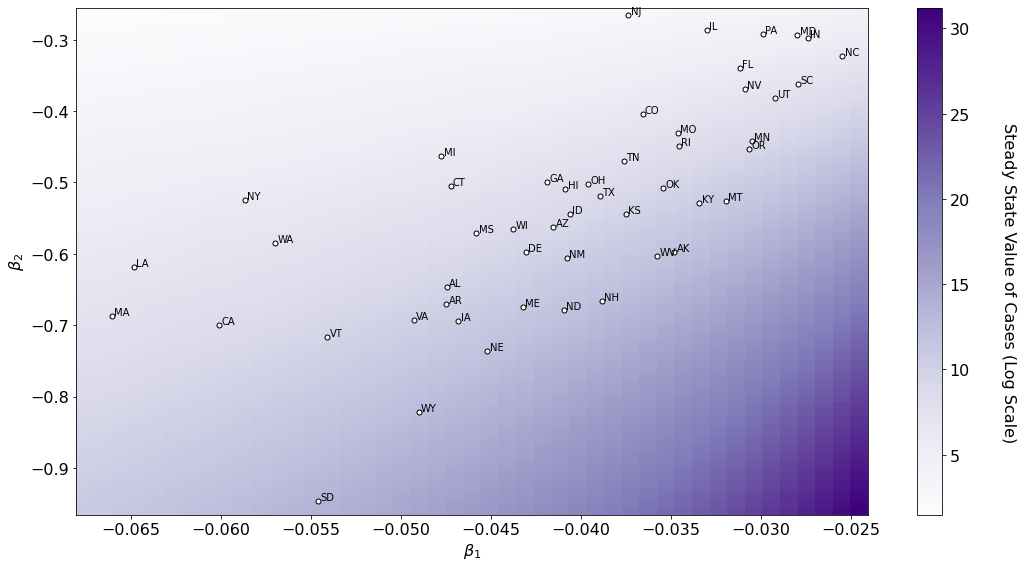

In [27]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 8))
pivotted = output_df.pivot(index='beta2', columns='beta1', values='z').iloc[::-1]


ax.scatter(coef_df['X1(t)'], coef_df['X3(t-1)'], s=25, color='white', marker='o', edgecolors='black')

x_offset = eps1/8
y_offset = eps2/8
for i, state in enumerate(coef_df.index):
    ax.annotate(us_state_abbrev[state], (coef_df.loc[state, 'X1(t)'] + x_offset, 
                                         coef_df.loc[state, 'X3(t-1)'] + y_offset))
    
ax.set_xlabel("$\\beta_1$", fontsize=16)
ax.set_ylabel("$\\beta_2$", fontsize=16)

pos = ax.imshow(pivotted.values, zorder=0, aspect="auto", extent=(min(beta1s),max(beta1s),min(beta2s),max(beta2s)), 
          cmap='Purples')

cbar = fig.colorbar(pos, ax=ax)
#cbar.set_label('Size of Epidemic (Log Scale)')
fig.text(0.93, 0.5, 'Steady State Value of Cases (Log Scale)', va='center', 
         rotation=270, fontsize=16)

#ax.set_title("Control Coefficients by State (Without Constant Term)")
fig.patch.set_facecolor('white')
fig.tight_layout()
# plt.savefig("state_coef_context.png")

## Figure 6
Comparison with different sets of regressors

In [28]:
## Can make different comparisons based
all_cols = [
    ['X3(t-1)'],
    ['X1(t)'],
    ['X1(t)', 'X3(t-1)'],
    ['X1(t)', 'X3(t-1)', 'sX(t-1)'],
    ['X1(t-1)', 'X3(t-2)'],
#     ['X1(t-1)'],
#     ['X1(t)', 'X3(t-1)', 'X1(t-2)'],
#     ['X1(t)', 'X3(t-1)', 'leakyIntegrator']
]

In [29]:
col_coefs = pd.DataFrame()
col_r2 = pd.DataFrame()
col_pvalue = pd.DataFrame()

for k, col in enumerate(all_cols):
    col_str = {
        'X3(t-1)': "log I(t) - log I(t-1) - log $\mathcal{R}$(0)",
        'X1(t)': "log I(t)",
        'X1(t), X3(t-1)': "log I(t), \n log I(t) - log I(t-1) - log $\mathcal{R}$(0)",
        'X1(t), X3(t-1), sX(t-1)': 
        "log I(t), \n log I(t) - log I(t-1) - log $\mathcal{R}$(0), \n $\sum_{k = 1}^t$ log I(k)",
        'X1(t-1), X3(t-2)': "log I(t-1), \n log I(t-1) - log I(t-2) - log $\mathcal{R}$(0)",
        'X1(t-1)': 'log I(t-1)',
        'X1(t), X3(t-1), X1(t-2)': 'log I(t), \n log I(t) - log I(t-1) - log $\mathcal{R}$(0), \n log I(t-2)',
        'X1(t), X3(t-1), leakyIntegrator': 'log I(t), \n log I(t) - log I(t-1) - log $\mathcal{R}$(0), \n leakyIntegrator'
    }[", ".join(col)]
    coefs_dict = {}
    pvalues_dict = {}
    models_dict = {}
    rsquared_dict = {}

    all_preds = []
    all_actual = []

    for curr_state in all_states:
        curr_df = df[df['state'] == curr_state]
        curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
        case_df = curr_df.set_index('date').resample('W-Sat').sum()
        case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
        case_df = case_df.iloc[:last_date]

        R0 = 2.5

        new_df = pd.DataFrame(index=case_df.index)
        new_df['X2(t)'] = np.log(case_df['weekly_cases'] + 1)
        new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1).shift(1).fillna(0)
        new_df['X1(t-1)'] = np.log(case_df['weekly_cases'] + 1).shift(2).fillna(0)
        new_df['X1(t-2)'] = np.log(case_df['weekly_cases'] + 1).shift(3).fillna(0)
        new_df['sX(t-1)'] = new_df['X1(t)'].cumsum().fillna(0)
        new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
        new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)
        new_df['X3(t-2)'] = new_df['X3(t)'].shift(2).fillna(0)
        new_df['leakyIntegrator'] = 0
        for i, x in new_df['X1(t)'].iteritems():
            curr_seen = new_df.loc[:i, ['X1(t)']].copy()
            alpha = 0.9
            curr_seen['weight'] = [alpha**(len(curr_seen) - i - 1) for i in range(len(curr_seen))]
            new_df.loc[:, 'leakyIntegrator'] = np.sum(curr_seen['weight'] * curr_seen['X1(t)'])
            
        X = new_df[col]
        y = new_df['X3(t)'] - new_df['X3(t-1)']


        ## learn beta1 and beta2
        model = sm.OLS(y,X)
        results = model.fit()

        models_dict[curr_state] = results
        coefs_dict[curr_state] = results.params
        pvalues_dict[curr_state] = results.pvalues

        new_df['Pred'] = results.predict(X) + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)

        new_df['Fitted'] = np.exp(new_df['Pred'])
        new_df['Actual'] = np.exp(new_df['X2(t)'])

        all_preds.append(new_df['Pred'])
        all_actual.append(new_df['X2(t)'])


        rsquared_dict[curr_state] = {
            'gamma': results.rsquared,
            'overall': r2_score(new_df['Fitted'], new_df['Actual'])
        }

    pvalue_df = pd.DataFrame(pvalues_dict).T
    pvalue_df['regressors'] = col_str
    col_pvalue = pd.concat([col_pvalue, pvalue_df])
    
    coef_df = pd.DataFrame(coefs_dict).T
    coef_df['regressors'] = col_str
    col_coefs = pd.concat([col_coefs, coef_df])
    
    rsquared_df = pd.DataFrame(rsquared_dict).T
    rsquared_df['regressors'] = col_str
    col_r2 = pd.concat([col_r2, rsquared_df])
    

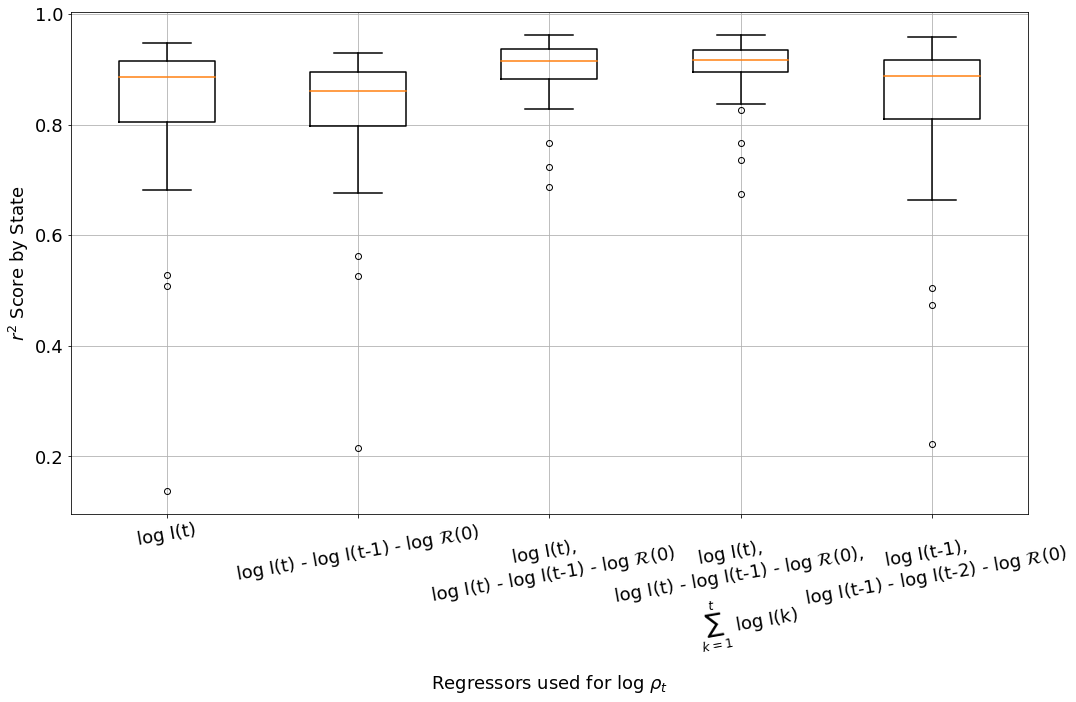

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
fig.patch.set_facecolor('white')
line_style = {"linewidth": 1.5}
col_r2[['regressors','overall']].boxplot(column=['overall'], by='regressors', ax=ax, 
                                         boxprops=line_style, capprops=line_style, 
                                         whiskerprops=line_style, medianprops=line_style)
fig.suptitle('')
ax.set_title("")
fig.tight_layout()
ax.set_ylabel("$r^2$ Score by State", fontsize=18)
ax.set_xlabel("Regressors used for log $\\rho_{t}$", fontsize=18)
plt.xticks(rotation = 10, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
# plt.savefig("lds_r2_integrator_trials.png", dpi=500)

## Figure 5
Synthetic simulations of the system

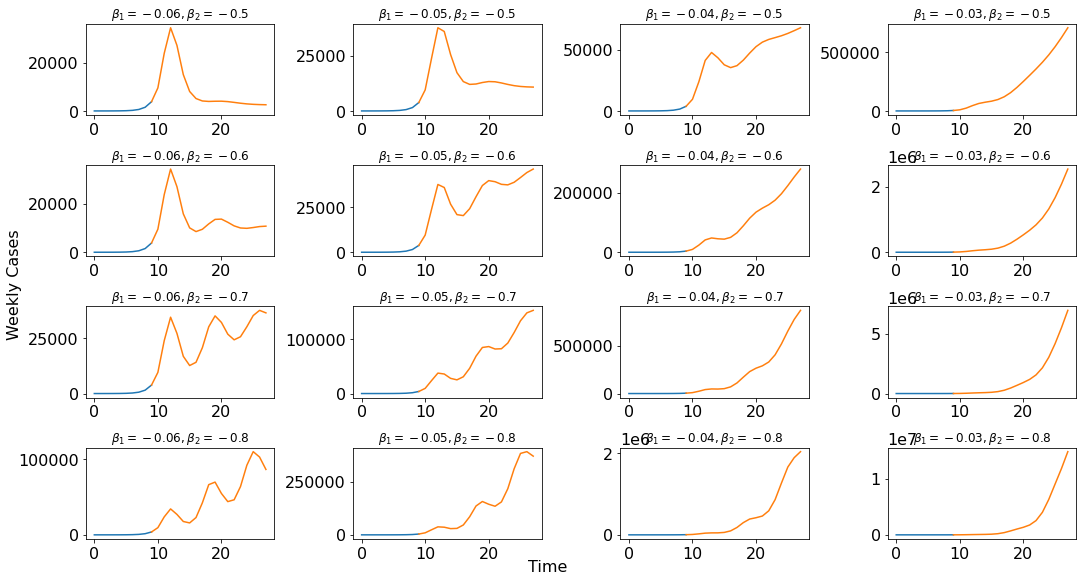

In [31]:
fig, axs = plt.subplots(4, 4, figsize=(15, 8))

beta1s = [-0.03, -0.04, -0.05, -0.06][::-1]
beta2s = [-0.5, -0.6, -0.7, -0.8]


init_size = 10
R0 = 2.5
out_size = 18


for k, beta1 in enumerate(beta1s):
    for j, beta2 in enumerate(beta2s):
        X1 = np.array([0])
        X2 = np.array([0])

        for i in range(init_size):
            X1 = np.append(X1, X1[i] + X2[i] + np.log(R0))
            X2 = np.append(X2, X2[i])
        
        init_X1 = X1[-1]
        init_X2 = X2[-1]

        for i in range(init_size, init_size + out_size):
            u = beta1 * X1[i] + beta2 * X2[i-1]
            X1 = np.append(X1, X1[i] + X2[i] + np.log(R0))
            X2 = np.append(X2, X2[i] + u)
        
        axs[j][k].plot(range(init_size), np.exp(X1[:init_size]), label='No Feedback')
        axs[j][k].plot(range(init_size-1, init_size + out_size), np.exp(X1[init_size-1:-1]), label='With Policy')
        axs[j][k].set_title( '$\\beta_1 = {beta1}, \\beta_2 = {beta2}$'.format(beta1=beta1, beta2=beta2), fontsize=12)

fig.patch.set_facecolor('white')
handles, labels = axs[0][0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper left')
# plt.suptitle(f'Initial condition of X1 = {round(init_X1, 3)}, X2 = {init_X2}')

fig.text(0.5, 0.0, 'Time', ha='center', fontsize=16)
fig.text(0.0, 0.5, 'Weekly Cases', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()  

# plt.savefig("state_beta_sweep.png")

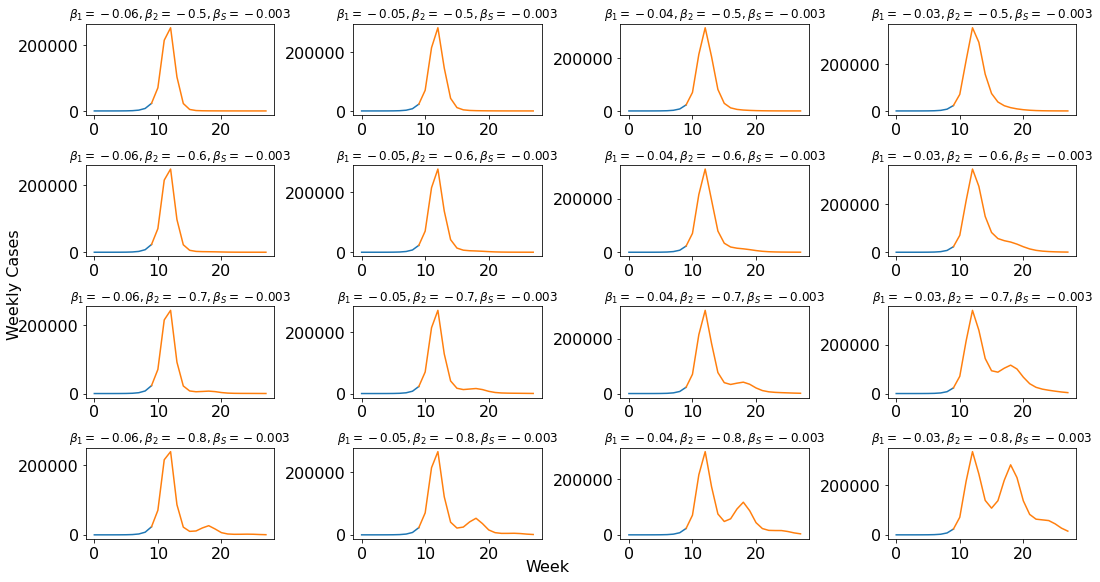

In [32]:
fig, axs = plt.subplots(4, 4, figsize=(15, 8))

beta1s = [-0.03, -0.04, -0.05, -0.06][::-1]
beta2s = [-0.5, -0.6, -0.7, -0.8]

beta3 = -0.003


init_size = 10
R0 = 2.5
out_size = 18


for k, beta1 in enumerate(beta1s):
    for j, beta2 in enumerate(beta2s):
        X1 = np.array([0])
        X2 = np.array([0.2])

        for i in range(init_size):
            X1 = np.append(X1, X1[i] + X2[i] + np.log(R0))
            X2 = np.append(X2, X2[i])
        
        init_X1 = X1[-1]
        init_X2 = X2[-1]

        for i in range(init_size, init_size + out_size):
            u = beta1 * X1[i] + beta2 * X2[i-1] + beta3 * np.sum(X1)
            X1 = np.append(X1, X1[i] + X2[i] + np.log(R0))
            X2 = np.append(X2, X2[i] + u)
        
        axs[j][k].plot(range(init_size), np.exp(X1[:init_size]), label='No Feedback')
        axs[j][k].plot(range(init_size-1, init_size + out_size), np.exp(X1[init_size-1:-1]), label='With Policy')
        axs[j][k].set_title(f'$\\beta_1 = {beta1}, \\beta_2 = {beta2}, \\beta_S = {beta3}$', fontsize=12)

fig.patch.set_facecolor('white')
handles, labels = axs[0][0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper left')
# plt.suptitle(f'Initial condition of X1 = {round(init_X1, 3)}, X2 = {init_X2}')
 
fig.text(0.5, 0.0, 'Week', ha='center', fontsize=16)
fig.text(0.0, 0.5, 'Weekly Cases', va='center', rotation='vertical', fontsize=16)
fig.tight_layout()  

# plt.savefig("state_beta_sweep_integrator.png")